# Low-light Image Enhancement using MirNetv2



🔍 Introduction

With the goal of recovering high-quality image content from its degraded version, image restoration enjoys numerous applications, such as in photography, security, medical imaging, and remote sensing. In this example, we implement the 🚀 MIRNet-v2 model for image enhancement, a fully-convolutional architecture that learns an enriched set of features that combines contextual information from multiple scales, while simultaneously preserving the high-resolution spatial details.

Although the MIRNet-v2 architecture can be applied to a variety of image restoration tasks such as single image denoising, super-resolution, image deblurring, etc, in this notebook, we would demonstrate an implementation of this architecture for low-light image enhancement using 📚 TensorFlow.

<a id="2"></a>
# 📦 Packages and Basic Setup
---

In [ ]:
!pip install tensorflow tensorflow_addons --upgrade --quiet
!pip install transformers --upgrade --quiet
!pip install git+https://github.com/wandb/wandb.git
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("wandb_api_key")


import random
import numpy as np
from glob import glob
from functools import partial
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
import tensorflow_addons as tfa
from transformers.tf_utils import shape_list

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint


AUTOTUNE = tf.data.AUTOTUNE

🚀 Setting up a Weights & Biases run 🎯
We would call wandb.init to initialize a new job which creates a new run in Weights & Biases and launches a background process to sync data. We sync all the configs of our experiments with the W&B run using 🔧 wandb.config, this makes it easier for us to reproduce the results of the experiment later.

In [ ]:
wandb.init(project="mirnet-v2", entity="ml-colabs", job_type="colab-train")

strategy = tf.distribute.MirroredStrategy()

config = wandb.config

config.seed = 42
random.seed(config.seed)
tf.random.set_seed(config.seed)

config.num_gpus = len(tf.config.list_physical_devices('GPU'))
config.dataset_artifact_address = 'ml-colabs/mirnet-v2/lol-dataset:v0'
config.image_size = 128
config.max_train_images = 400
config.batch_size_per_replica = 4
config.batch_size = config.batch_size_per_replica * strategy.num_replicas_in_sync

config.channels = 80
config.channel_factor = 1.5
config.num_mrb_blocks = 2
config.add_residual_connection = True

config.initial_learning_rate = 2e-4
config.minimum_learning_rate = 1e-6
config.epochs = 100

<a id="4"></a>
# 💿 The LOL Dataset
---

<center><img src="https://i.imgur.com/0LKfMgF.png" height="75%" width="75%"></center><br>

The **LoL Dataset** or **LOw Light paired dataset** \[[Original Source](https://daooshee.github.io/BMVC2018website/) | [Kaggle Dataset](https://www.kaggle.com/datasets/soumikrakshit/lol-dataset)\] was created for training supervised models for low-light image enhancements.  This dataset provides 📊 485 images for training and 🎯 15 for testing. Each image pair in the dataset consists of a low-light input image and its corresponding well-exposed reference image.

In [ ]:
dataset_dir = "/content/lol-dataset/lol_dataset"
TRAIN_LOW_LIGHT_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "our485/low/*"))
)[:config.max_train_images]
TRAIN_GROUND_TRUTH_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "our485/high/*"))
)[:config.max_train_images]

VAL_LOW_LIGHT_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "our485/low/*"))
)[config.max_train_images:]
VAL_GROUND_TRUTH_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "our485/high/*"))
)[config.max_train_images:]

TEST_LOW_LIGHT_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "eval15/low/*"))
)
TEST_GROUND_TRUTH_IMAGES = sorted(
    glob(os.path.join(dataset_dir, "eval15/high/*"))
)

print(f"Train Dataset: ({len(TRAIN_LOW_LIGHT_IMAGES)}, {len(TRAIN_GROUND_TRUTH_IMAGES)})")
print(f"Validation Dataset: ({len(VAL_LOW_LIGHT_IMAGES)}, {len(VAL_GROUND_TRUTH_IMAGES)})")
print(f"Test Dataset: ({len(TEST_LOW_LIGHT_IMAGES)}, {len(TEST_GROUND_TRUTH_IMAGES)})")

Train Dataset: (400, 400)
Validation Dataset: (85, 85)
Test Dataset: (15, 15)


Let us take a look at few samples of training data...

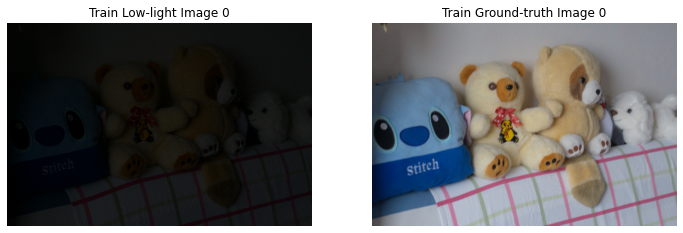

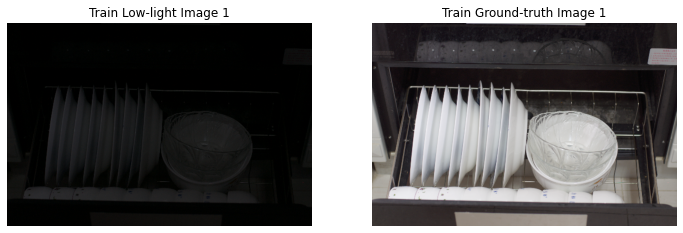

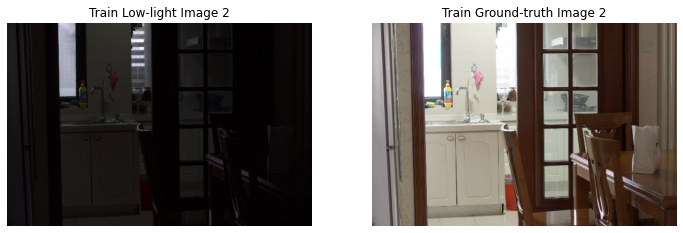

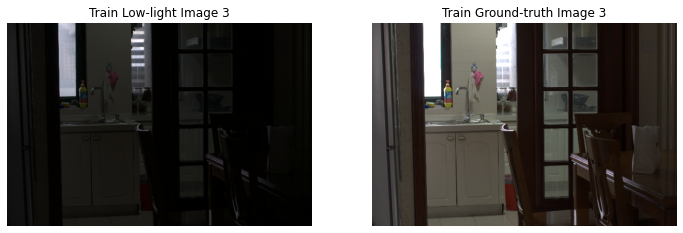

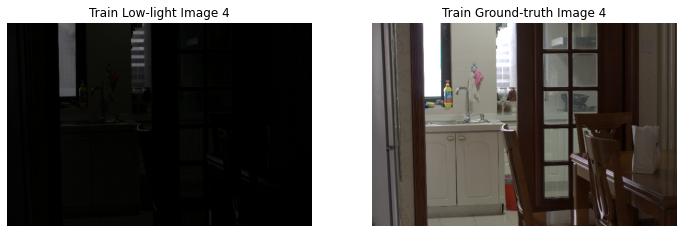

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    """A simple utility for plotting the results"""
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

    
for idx, (low_light_image, ground_truth_image) in enumerate(zip(TRAIN_LOW_LIGHT_IMAGES[:5], TRAIN_GROUND_TRUTH_IMAGES[:5])):
    plot_results(
        [Image.open(low_light_image), Image.open(ground_truth_image)],
        [f"Train Low-light Image {idx}", f"Train Ground-truth Image {idx}"]
    )

🎛️ The Input Pipeline

Tensorflow provided the tf.data API that makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations in our machine learning workflows. The tf.data API introduces a 🚀 tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components.

We would use tf.data.Dataset to create a simple, descriptive and efficient input pipeline that would enable us to aggregate the data from image files, preprocess them and provide to the training pipeline on the fly.

For a detailed guide on how to build an input pipeline for a Tensorflow-based machine learning workflow, you can refer to the 📚 official guide.

To create an input pipeline, we must start with a data source, which in our case is the list of image file paths. Once we have a Dataset object, we can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object.

The Dataset.map(function) transformation produces a new dataset by applying a given function to each element of the input dataset. The function takes the tf.Tensor objects that represent a single element in the input, and returns the tf.Tensor objects that will represent a single element in the new dataset. We implement this function load_data using standard TensorFlow operations to load, transform and preprocess the data from the image files.

In this case, we first load the images into tensors.

Then we transform the tensors into a fixed spatial dimension either by applying a random crop (in case of the training data) or by resizing (in case of the validation data).

We would apply the simplest form of batching in our input pipeline using the Dataset.batch() that stacks a fixed number of consecutive elements of a dataset into a single element.

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing a certain training step, the input pipeline is reading the data for the next step. Doing so reduces the step time to the maximum of the training and the time it takes to extract the data. We would perform prefetching using the Dataset.prefetch() transform.

In [ ]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, gt_image):
    low_image_shape = tf.shape(low_image)[:2]
    crop_width = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - config.image_size + 1, dtype=tf.int32
    )
    crop_height = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - config.image_size + 1, dtype=tf.int32
    )
    low_image_cropped = low_image[
        crop_height : crop_height + config.image_size,
        crop_width : crop_width + config.image_size
    ]
    gt_image_cropped = gt_image[
        crop_height : crop_height + config.image_size,
        crop_width : crop_width + config.image_size
    ]
    low_image_cropped.set_shape([config.image_size, config.image_size, 3])
    gt_image_cropped.set_shape([config.image_size, config.image_size, 3])
    return low_image_cropped, gt_image_cropped


def resize_images(low_image, gt_image):
    low_image = tf.image.resize(low_image, size=[config.image_size, config.image_size])
    gt_image = tf.image.resize(gt_image, size=[config.image_size, config.image_size])
    low_image.set_shape([config.image_size, config.image_size, 3])
    gt_image.set_shape([config.image_size, config.image_size, 3])
    return low_image, gt_image


def load_data(low_light_image_path, enhanced_image_path, apply_resize):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = (
        resize_images(low_light_image, enhanced_image) if apply_resize
        else random_crop(low_light_image, enhanced_image)
    )
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images, apply_resize):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(
        partial(load_data, apply_resize=apply_resize),
        num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.batch(config.batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
train_dataset = get_dataset(TRAIN_LOW_LIGHT_IMAGES, TRAIN_GROUND_TRUTH_IMAGES, apply_resize=False)
val_dataset = get_dataset(VAL_LOW_LIGHT_IMAGES, VAL_GROUND_TRUTH_IMAGES, apply_resize=True)

print("Train Dataset:", train_dataset.element_spec)
print("Validation Dataset:", val_dataset.element_spec)

Train Dataset: (TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None))
Validation Dataset: (TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 128, 128, 3), dtype=tf.float32, name=None))


🧠 The MirNet-v2 Architecture


MIRNet-v2, as proposed by the paper 📚 Learning Enriched Features for Fast Image Restoration and Enhancement is a fully convolutional architecture that learns enriched feature representations for image restoration and enhancement. It is based on a recursive residual design with the multi-scale residual block or MRB at its core. The main branch of the MRB is dedicated to maintaining spatially-precise high-resolution representations through the entire network and the complimentary set of parallel branches provide better contextualized features.

The main features of the MIRNet-v2 architecture are:

✨ A novel feature extraction model that obtains a complementary set of features across multiple spatial scales, while maintaining the original high-resolution features to preserve precise spatial details.

🔄 A regularly repeated mechanism for information exchange, where the features from coarse-to-fine resolution branches are progressively fused together for improved representation learning.

🌐 A new approach to fuse multi-scale features using a selective kernel network that dynamically combines variable receptive fields and faithfully preserves the original feature information at each spatial resolution.

🌀 A recursive residual design that progressively breaks down the input signal to simplify the overall learning process and allows the construction of very deep networks.

<center><img src="https://i.imgur.com/L7ujhS8.png" width="85%" height="85%"></center>

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
MIRNet-v2 is a significant improvement on the original <a href="https://arxiv.org/abs/2003.06792">MIRNet</a> model for image enhancement in terms of performance, while being significantly lighter and faster.
</div>


🔍 Selective Kernel Feature Fusion

An important fundamental property of neurons present in the primate visual cortex is their ability to change receptive fields according to the stimulus. This mechanism of adaptively adjusting receptive fields can be incorporated in CNNs by using multi-scale feature generation (in the same layer) followed by feature aggregation and selection. The most commonly used approaches for feature aggregation include simple concatenation or summation. In MIRNet-v2, a nonlinear procedure is used for fusing features coming from different resolution streams using a self-attention mechanism inspired by the paper Selective Kernel Networks. This procedure is named as 🎯 Selective Kernel Feature Fusion or SKFF. The SKFF module performs dynamic adjustment of receptive fields via two operations: Fuse and Select.

The Fuse Operator
The fuse operator generates global feature descriptors by combining the information from multiresolution streams.

The SKFF module receives inputs from two parallel convolution streams carrying different scales of information. These multi-scale features are first combined using 🔄 element-wise summation.

Across the spatial dimension of the combined features, Global Average Pooling or GAP is applied to compute 📊 channel-wise statistics.

Next, a channel-downscaling convolution layer is applied to the channel-wise statistics to generate a 🌟 compact feature representation.

Finally, the compact feature vector passes through two parallel channel-upscaling convolution layers (one for each resolution stream) and provides us with two 🌈 feature descriptors.

The Select Operator
The select operator uses the feature descriptors generated by the fuse operator to recalibrate the feature maps (of different streams) followed by their aggregation.

First SoftMax is applied to the feature descriptors to generate 🔥 attention activations.

These attention activations are used to adaptively recalibrate the original multi-scale feature maps. The overall process of feature recalibration and aggregation is defined as $U = s_{1} L_{1} + s_{2} L_{2}$ where $L_{1}$ and $L_{2}$ are the multi-scale feature maps and $s_{1}$ and $s_{2}$ are the corresponding attention activations.

<br><center><img src="https://i.imgur.com/guIj8NZ.png" height="85%" width="85%"></center>


In [ ]:
class SelectiveKernelFeatureFusion(tf.keras.layers.Layer):
    def __init__(self, channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.hidden_channels = max(int(channels / 8), 4)

        self.average_pooling = tfa.layers.AdaptiveAveragePooling2D(output_size=1)

        self.conv_channel_downscale = tf.keras.layers.Conv2D(
            self.hidden_channels, kernel_size=1, padding="same"
        )
        self.conv_attention_1 = tf.keras.layers.Conv2D(
            channels, kernel_size=1, strides=1, padding="same"
        )
        self.conv_attention_2 = tf.keras.layers.Conv2D(
            channels, kernel_size=1, strides=1, padding="same"
        )

        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.sorftmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs, *args, **kwargs):
        combined_input_features = inputs[0] + inputs[1]
        channel_wise_statistics = self.average_pooling(combined_input_features)
        downscaled_channel_wise_statistics = self.conv_channel_downscale(
            channel_wise_statistics
        )
        attention_vector_1 = self.sorftmax(
            self.conv_attention_1(downscaled_channel_wise_statistics)
        )
        attention_vector_2 = self.sorftmax(
            self.conv_attention_2(downscaled_channel_wise_statistics)
        )
        selected_features = (
            inputs[0] * attention_vector_1 + inputs[1] * attention_vector_2
        )
        return selected_features

🌌 Residual Contextual Block

While the SKFF block fuses information across multiresolution branches, we also need a distillation mechanism to extract useful information from within a feature tensor. MIRNet-v2 uses the 🎯 residual contextual block RCB in order to extract features in the convolutional streams. The RCB suppresses less useful features and only allows more informative ones to pass further. The overall process of RCB is summarized as:

$$F_{RCB} = F_{a} + W(CM(F_{b}))$$

where...

$F_{a}$ are the input feature maps

$F_{b}$ represents feature maps that are obtained by applying two 3x3 group convolution layers to the input features

$CM$ represents a 🧠 contextual module

$W$ denotes the last convolutional layer with filter size $1 \times 1$.


We apply group convolutions to the input feature maps instead of standard convolutions because group convolutions are more efficient and capable of learning unique representations in each filter group.

The Contextual Module
The Contextural Module consists of 3 parts:

1)Context Modelling

From the original feature maps $F_{b}$, we first generate new features $F_{c}$ by applying $1 \times 1$ convolution followed by the reshaping and softmax operations.

Next we reshape $F_{b}$ and perform matrix multiplication with $F_{c}$ to obtain the global feature descriptor $F_{d}$.

2)Feature Transform: In order to capture the inter-channel dependencies, the descriptor $F_{d}$ is passed through two $1 \times 1$ convolutions, resulting in new attention features $F_{e}$.

3)Feature fusion: In this step, the element-wise addition operation is employed to aggregate contextual features $F_{e}$ to each position of the original features $F_{b}$.

<br><center><img src="https://i.imgur.com/z2QcJ5j.png" height="85%" width="85%"></center>

In [ ]:
class ContextBlock(tf.keras.layers.Layer):
    def __init__(self, channels: int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mask_conv = tf.keras.layers.Conv2D(
            1, kernel_size=1, padding="same"
        )

        self.channel_add_conv_1 = tf.keras.layers.Conv2D(
            channels, kernel_size=1, padding="same"
        )
        self.channel_add_conv_2 = tf.keras.layers.Conv2D(
            channels, kernel_size=1, padding="same"
        )

        self.softmax = tf.keras.layers.Softmax(axis=1)
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    def modeling(self, inputs):
        _, height, width, channels = shape_list(inputs)
        reshaped_inputs = tf.expand_dims(
            tf.reshape(inputs, (-1, channels, height * width)), axis=1
        )

        context_mask = self.mask_conv(inputs)
        context_mask = tf.reshape(context_mask, (-1, height * width, 1))
        context_mask = self.softmax(context_mask)
        context_mask = tf.expand_dims(context_mask, axis=1)

        context = tf.reshape(
            tf.matmul(reshaped_inputs, context_mask), (-1, 1, 1, channels)
        )
        return context

    def call(self, inputs, *args, **kwargs):
        context = self.modeling(inputs)
        channel_add_term = self.channel_add_conv_1(context)
        channel_add_term = self.leaky_relu(channel_add_term)
        channel_add_term = self.channel_add_conv_2(channel_add_term)
        return inputs + channel_add_term


class ResidualContextBlock(tf.keras.layers.Layer):
    def __init__(self, channels: int, groups: int, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv_1 = tf.keras.layers.Conv2D(
            channels, kernel_size=3, padding="same", groups=groups
        )
        self.conv_2 = tf.keras.layers.Conv2D(
            channels, kernel_size=3, padding="same", groups=groups
        )
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

        self.context_block = ContextBlock(channels=channels)

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.leaky_relu(x)
        x = self.conv_2(x)
        x = self.context_block(x)
        x = self.leaky_relu(x)
        x = x + inputs
        return x

🔭 Multi-Scale Residual Block

In order to encode context, CNNs-based architecture typically employ the following architecture design:

The receptive field of neurons is fixed in each layer/stage.

The spatial size of feature maps is gradually reduced to generate a semantically strong low-resolution representation.

A high-resolution representation is gradually recovered from the low-resolution representation.

However, it is well-understood in vision science that in the primate visual cortex, the sizes of the local receptive fields of neurons in the same region are different. Therefore, a similar mechanism of collecting multiscale spatial information in the same layer is more effective when incorporated with in CNNs which motivates the formulation of the 🌐 Multi-Scale Residual Block in MIRNet-v2. The key advantages of MRB are:

It is capable of generating a spatially-precise output by maintaining high-resolution representations, while receiving rich contextual information from low-resolutions.

It allows contextualized-information transfer from the low-resolution streams to consolidate the high-resolution features.

The MRB module forms the core component of the recursive residual design of MIRNet-v2 and consists of all the convolutional design elements we have discussed so far.

<br><center><img src="https://i.imgur.com/nmOlSjY.png" height="85%" width="85%"></center>

In [ ]:
class DownBlock(tf.keras.layers.Layer):
    def __init__(
        self, channels: int, channel_factor: float, *args, **kwargs
    ):
        super(DownBlock, self).__init__(*args, **kwargs)
        self.average_pool = tf.keras.layers.AveragePooling2D(
            pool_size=2, strides=2
        )
        self.conv = tf.keras.layers.Conv2D(
            int(channels * channel_factor),
            kernel_size=1,
            strides=1,
            padding="same"
        )

    def call(self, inputs, *args, **kwargs):
        return self.conv(self.average_pool(inputs))


class DownSampleBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        channels: int,
        scale_factor: int,
        channel_factor: float,
        *args,
        **kwargs
    ):
        super(DownSampleBlock, self).__init__(*args, **kwargs)
        self.layers = []
        for _ in range(int(np.log2(scale_factor))):
            self.layers.append(DownBlock(channels, channel_factor))
            channels = int(channels * channel_factor)

    def call(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class UpBlock(tf.keras.layers.Layer):
    def __init__(self, channels: int, channel_factor: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = tf.keras.layers.Conv2D(
            int(channels // channel_factor), kernel_size=1, strides=1, padding="same"
        )
        self.upsample = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, *args, **kwargs):
        return self.upsample(self.conv(inputs))


class UpSampleBlock(tf.keras.layers.Layer):
    def __init__(
        self, channels: int, scale_factor: int, channel_factor: float, *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.layers = []
        for _ in range(int(np.log2(scale_factor))):
            self.layers.append(UpBlock(channels, channel_factor))
            channels = int(channels // channel_factor)

    def call(self, x, *args, **kwargs):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class MultiScaleResidualBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        channels: int,
        channel_factor: float,
        groups: int,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)

        # Residual Context Blocks
        self.rcb_top = ResidualContextBlock(
            int(channels * channel_factor**0), groups=groups
        )
        self.rcb_middle = ResidualContextBlock(
            int(channels * channel_factor**1), groups=groups
        )
        self.rcb_bottom = ResidualContextBlock(
            int(channels * channel_factor**2), groups=groups
        )

        # Downsample Blocks
        self.down_2 = DownSampleBlock(
            channels=int((channel_factor**0) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )
        self.down_4_1 = DownSampleBlock(
            channels=int((channel_factor ** 0) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )
        self.down_4_2 = DownSampleBlock(
            channels=int((channel_factor ** 1) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )

        # UpSample Blocks
        self.up21_1 = UpSampleBlock(
            channels=int((channel_factor ** 1) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )
        self.up21_2 = UpSampleBlock(
            channels=int((channel_factor ** 1) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )
        self.up32_1 = UpSampleBlock(
            channels=int((channel_factor ** 2) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )
        self.up32_2 = UpSampleBlock(
            channels=int((channel_factor ** 2) * channels),
            scale_factor=2,
            channel_factor=channel_factor,
        )

        # SKFF Blocks
        self.skff_top = SelectiveKernelFeatureFusion(
            channels=int(channels * channel_factor**0)
        )
        self.skff_middle = SelectiveKernelFeatureFusion(
            channels=int(channels * channel_factor**1)
        )

        # Convolution
        self.conv_out = tf.keras.layers.Conv2D(
            channels, kernel_size=1, padding="same"
        )

    def call(self, inputs, *args, **kwargs):
        x_top = inputs
        x_middle = self.down_2(x_top)
        x_bottom = self.down_4_2(self.down_4_1(x_top))

        x_top = self.rcb_top(x_top)
        x_middle = self.rcb_middle(x_middle)
        x_bottom = self.rcb_bottom(x_bottom)

        x_middle = self.skff_middle([x_middle, self.up32_1(x_bottom)])
        x_top = self.skff_top([x_top, self.up21_1(x_middle)])

        x_top = self.rcb_top(x_top)
        x_middle = self.rcb_middle(x_middle)
        x_bottom = self.rcb_bottom(x_bottom)

        x_middle = self.skff_middle([x_middle, self.up32_2(x_bottom)])
        x_top = self.skff_top([x_top, self.up21_2(x_middle)])

        output = self.conv_out(x_top)
        output = output + inputs

        return output

## Putting Everything Together in MIRNet-v2

In [ ]:
class RecursiveResidualGroup(tf.keras.layers.Layer):
    def __init__(
        self,
        channels: int,
        num_mrb_blocks: int,
        channel_factor: float,
        groups: int,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.layers = [
            MultiScaleResidualBlock(channels, channel_factor, groups)
            for _ in range(num_mrb_blocks)
        ]
        self.layers.append(
            tf.keras.layers.Conv2D(
                channels, kernel_size=3, strides=1, padding="same"
            )
        )

    def call(self, inputs, *args, **kwargs):
        residual = inputs
        for layer in self.layers:
            residual = layer(residual)
        residual = residual + inputs
        return residual


class MirNetv2(tf.keras.Model):
    def __init__(
        self,
        channels: int,
        channel_factor: float,
        num_mrb_blocks: int,
        add_residual_connection: bool,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)

        self.add_residual_connection = add_residual_connection

        self.conv_in = tf.keras.layers.Conv2D(
            channels, kernel_size=3, padding="same"
        )

        self.rrg_block_1 = RecursiveResidualGroup(
            channels, num_mrb_blocks, channel_factor, groups=1
        )
        self.rrg_block_2 = RecursiveResidualGroup(
            channels, num_mrb_blocks, channel_factor, groups=2
        )
        self.rrg_block_3 = RecursiveResidualGroup(
            channels, num_mrb_blocks, channel_factor, groups=4
        )
        self.rrg_block_4 = RecursiveResidualGroup(
            channels, num_mrb_blocks, channel_factor, groups=4
        )

        self.conv_out = tf.keras.layers.Conv2D(
            3, kernel_size=3, padding="same"
        )

    def call(self, inputs, training=None, mask=None):
        shallow_features = self.conv_in(inputs)
        deep_features = self.rrg_block_1(shallow_features)
        deep_features = self.rrg_block_2(deep_features)
        deep_features = self.rrg_block_3(deep_features)
        deep_features = self.rrg_block_4(deep_features)
        output = self.conv_out(deep_features)
        output = output + inputs if self.add_residual_connection else output
        return output

📉 Losses and Metrics 📈


Charbonnier Loss
We utilize the 🎯 Charbonnier Loss for training MIRNet-v2 for the low-light enhancement task. It is essentially a differentiable version of the L1 norm. It is given by $\rho = \sqrt{x^{2} + \epsilon^{2}}$ where the parameter $\epsilon$ determines how closely the loss resembles the L1 penalty while remaining differentiable.



Peak Signal-to-Noise Ratio
Peak signal-to-noise ratio or PSNR is defined as the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. Since many signals have a very wide dynamic range, PSNR is usually expressed as a logarithmic quantity using the decibel scale.



Structural Similarity
The 🌈 structural similarity index measure or SSIM is a method for predicting the perceived quality of digital television and cinematic pictures, as well as other kinds of digital images and videos. SSIM is used for measuring the similarity between two images.

In [ ]:
class CharbonnierLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epsilon = tf.convert_to_tensor(epsilon)

    def call(self, y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(
            tf.sqrt(squared_difference + tf.square(self.epsilon))
        )


class PSNRMetric(tf.keras.metrics.Metric):
    def __init__(self, max_val: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_val = max_val
        self.psnr = tf.keras.metrics.Mean(name="psnr")

    def update_state(self, y_true, y_pred, *args, **kwargs):
        psnr = tf.image.psnr(y_true, y_pred, max_val=self.max_val)
        self.psnr.update_state(psnr, *args, **kwargs)

    def result(self):
        return self.psnr.result()

    def reset_state(self):
        self.psnr.reset_state()


class SSIMMetric(tf.keras.metrics.Metric):
    def __init__(self, max_val: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_val = max_val
        self.ssim = tf.keras.metrics.Mean(name="ssim")

    def update_state(self, y_true, y_pred, *args, **kwargs):
        ssim = tf.image.ssim(y_true, y_pred, max_val=self.max_val)
        self.ssim.update_state(ssim, *args, **kwargs)

    def result(self):
        return self.ssim.result()

    def reset_state(self):
        self.ssim.reset_state()

🏋️ Distributed Training


The tf.distribute.Strategy API provides an abstraction for distributing your training across multiple processing units. It allows you to carry out distributed training using existing models and training code with minimal changes. In this notebook, we utilize the 🌐 tf.distribute.MirroredStrategy to perform in-graph replication with synchronous training on many GPUs (2 Tesla T4 GPUs in the case of this notebook on Kaggle) on one machine. The strategy essentially copies all of the model's variables to each processor. Then, it uses all-reduce to combine the gradients from all processors and applies the combined value to all copies of the model. As per the official TensorFlow guide on distributed training, we create and compile the model inside the context of strategy.scope.

In [ ]:
with strategy.scope():
    model = MirNetv2(
        channels=config.channels,
        channel_factor=config.channel_factor,
        num_mrb_blocks=config.num_mrb_blocks,
        add_residual_connection=config.add_residual_connection
    )

    dummy_inputs = tf.ones((1, config.image_size, config.image_size, 3))
    dummy_outputs = model(dummy_inputs)
    model.summary(expand_nested=True)
    print("\nInput Shape:", dummy_inputs.shape)
    print("Output Shape:", dummy_outputs.shape)
    
    loss = CharbonnierLoss(epsilon=1e-3)

    psnr_metric = PSNRMetric(max_val=1.0)
    ssim_metric = SSIMMetric(max_val=1.0)

    decay_steps = (config.max_train_images // config.batch_size) * config.epochs
    lr_schedule_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=config.initial_learning_rate,
        decay_steps=decay_steps,
        alpha=config.minimum_learning_rate,
    )
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule_fn, beta_1=0.9, beta_2=0.999,
    )

    model.compile(
        optimizer=optimizer, loss=loss, metrics=[psnr_metric, ssim_metric]
    )

Model: "mir_netv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2240      
                                                                 
 recursive_residual_group (R  multiple                 2426936   
 ecursiveResidualGroup)                                          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| multi_scale_residual_block   multiple               1184628   |
| (MultiScaleResidualBlock)                                     |
|                                                               |
| multi_scale_residual_block_  multiple               1184628   |
| 1 (MultiScaleResidualBlock)                                   |
|                                                               |
| conv2d_59 (Conv2D)        multiple                  57680     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Experiment Tracking using Weights & Biases


Weights & Biases offers a set of callbacks for experiment tracking in Keras and TensorFlow workflows. We will be using 2 of these callbacks:

WandbMetricsLogger: This callback automatically logs Keras' logs dictionary that callback methods such as on_epoch_end, on_batch_end, etc., take as an argument. Using this provides:

Train and validation metrics defined in model.compile

System (CPU/GPU/TPU) metrics

Learning rate (both for a fixed value or a learning rate scheduler)

WandbModelCheckpoint: This callback is used to save the Keras model (SavedModel format) or model weights periodically and uploads them to W&B as a wandb.Artifact for model versioning. You can learn more about model versioning here. This callback is subclassed from tf.keras.callbacks.ModelCheckpoint, thus the checkpointing logic is taken care of by the parent callback. This callback provides the following features:

Save the model that has achieved "best performance" based on the "monitor".

Save the model at the end of every epoch regardless of the performance.

Save the model at the end of the epoch or after a fixed number of training batches.

Save only model weights, or save the whole model.

Save the model either in SavedModel format or in .h5 format.



In [ ]:
%%wandb

callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="model", save_best_only=False)
]

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs,
    callbacks=callbacks
)


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.1999 - psnr_metric: 13.9624 - ssim_metric: 0.6141

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 348s 3s/step - loss: 0.1999 - psnr_metric: 13.9624 - ssim_metric: 0.6141 - val_loss: 0.2110 - val_psnr_metric: 13.3902 - val_ssim_metric: 0.6521
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.1636 - psnr_metric: 15.5451 - ssim_metric: 0.6684

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 110s 2s/step - loss: 0.1636 - psnr_metric: 15.5451 - ssim_metric: 0.6684 - val_loss: 0.2119 - val_psnr_metric: 13.3679 - val_ssim_metric: 0.6853
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.1566 - psnr_metric: 16.0071 - ssim_metric: 0.6805

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 112s 2s/step - loss: 0.1566 - psnr_metric: 16.0071 - ssim_metric: 0.6805 - val_loss: 0.1997 - val_psnr_metric: 13.8387 - val_ssim_metric: 0.7033
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.1545 - psnr_metric: 16.1582 - ssim_metric: 0.6831

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 112s 2s/step - loss: 0.1545 - psnr_metric: 16.1582 - ssim_metric: 0.6831 - val_loss: 0.2080 - val_psnr_metric: 13.5181 - val_ssim_metric: 0.7064
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.1494 - psnr_metric: 16.3707 - ssim_metric: 0.6904

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1494 - psnr_metric: 16.3707 - ssim_metric: 0.6904 - val_loss: 0.1776 - val_psnr_metric: 14.8105 - val_ssim_metric: 0.7270
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.1532 - psnr_metric: 16.2449 - ssim_metric: 0.6886

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1532 - psnr_metric: 16.2449 - ssim_metric: 0.6886 - val_loss: 0.2053 - val_psnr_metric: 13.6241 - val_ssim_metric: 0.7156
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 0.1487 - psnr_metric: 16.6950 - ssim_metric: 0.6965

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.1487 - psnr_metric: 16.6950 - ssim_metric: 0.6965 - val_loss: 0.2083 - val_psnr_metric: 13.4800 - val_ssim_metric: 0.6989
Epoch 8/100
50/50 [==============================] - ETA: 0s - loss: 0.1460 - psnr_metric: 16.7046 - ssim_metric: 0.6928

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 111s 2s/step - loss: 0.1460 - psnr_metric: 16.7046 - ssim_metric: 0.6928 - val_loss: 0.1730 - val_psnr_metric: 15.2545 - val_ssim_metric: 0.7411
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 0.1444 - psnr_metric: 17.0871 - ssim_metric: 0.7020

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 110s 2s/step - loss: 0.1444 - psnr_metric: 17.0871 - ssim_metric: 0.7020 - val_loss: 0.1979 - val_psnr_metric: 14.1245 - val_ssim_metric: 0.7253
Epoch 10/100
50/50 [==============================] - ETA: 0s - loss: 0.1350 - psnr_metric: 17.2819 - ssim_metric: 0.6937

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1350 - psnr_metric: 17.2819 - ssim_metric: 0.6937 - val_loss: 0.1808 - val_psnr_metric: 14.7312 - val_ssim_metric: 0.7334
Epoch 11/100
50/50 [==============================] - ETA: 0s - loss: 0.1284 - psnr_metric: 17.8117 - ssim_metric: 0.7062

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 110s 2s/step - loss: 0.1284 - psnr_metric: 17.8117 - ssim_metric: 0.7062 - val_loss: 0.1662 - val_psnr_metric: 15.4455 - val_ssim_metric: 0.7473
Epoch 12/100
50/50 [==============================] - ETA: 0s - loss: 0.1297 - psnr_metric: 17.8740 - ssim_metric: 0.7107

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 111s 2s/step - loss: 0.1297 - psnr_metric: 17.8740 - ssim_metric: 0.7107 - val_loss: 0.1587 - val_psnr_metric: 15.5783 - val_ssim_metric: 0.7509
Epoch 13/100
50/50 [==============================] - ETA: 0s - loss: 0.1322 - psnr_metric: 17.6753 - ssim_metric: 0.7050

wandb: Adding directory to artifact (./model)... Done. 0.6s


50/50 [==============================] - 110s 2s/step - loss: 0.1322 - psnr_metric: 17.6753 - ssim_metric: 0.7050 - val_loss: 0.1669 - val_psnr_metric: 15.3160 - val_ssim_metric: 0.7496
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 0.1196 - psnr_metric: 18.4292 - ssim_metric: 0.7159

wandb: Adding directory to artifact (./model)... Done. 1.0s


50/50 [==============================] - 111s 2s/step - loss: 0.1196 - psnr_metric: 18.4292 - ssim_metric: 0.7159 - val_loss: 0.1625 - val_psnr_metric: 15.5373 - val_ssim_metric: 0.7549
Epoch 15/100
50/50 [==============================] - ETA: 0s - loss: 0.1272 - psnr_metric: 18.0510 - ssim_metric: 0.7148

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.1272 - psnr_metric: 18.0510 - ssim_metric: 0.7148 - val_loss: 0.1512 - val_psnr_metric: 16.0533 - val_ssim_metric: 0.7532
Epoch 16/100
50/50 [==============================] - ETA: 0s - loss: 0.1214 - psnr_metric: 18.2492 - ssim_metric: 0.7168

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1214 - psnr_metric: 18.2492 - ssim_metric: 0.7168 - val_loss: 0.1416 - val_psnr_metric: 16.7075 - val_ssim_metric: 0.7639
Epoch 17/100
50/50 [==============================] - ETA: 0s - loss: 0.1200 - psnr_metric: 18.3931 - ssim_metric: 0.7169

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.1200 - psnr_metric: 18.3931 - ssim_metric: 0.7169 - val_loss: 0.1492 - val_psnr_metric: 16.4022 - val_ssim_metric: 0.7594
Epoch 18/100
50/50 [==============================] - ETA: 0s - loss: 0.1209 - psnr_metric: 18.3967 - ssim_metric: 0.7138

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1209 - psnr_metric: 18.3967 - ssim_metric: 0.7138 - val_loss: 0.1508 - val_psnr_metric: 16.2859 - val_ssim_metric: 0.7614
Epoch 19/100
50/50 [==============================] - ETA: 0s - loss: 0.1205 - psnr_metric: 18.5301 - ssim_metric: 0.7242

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1205 - psnr_metric: 18.5301 - ssim_metric: 0.7242 - val_loss: 0.1384 - val_psnr_metric: 17.0329 - val_ssim_metric: 0.7677
Epoch 20/100
50/50 [==============================] - ETA: 0s - loss: 0.1113 - psnr_metric: 19.0964 - ssim_metric: 0.7320

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1113 - psnr_metric: 19.0964 - ssim_metric: 0.7320 - val_loss: 0.1406 - val_psnr_metric: 16.9317 - val_ssim_metric: 0.7685
Epoch 21/100
50/50 [==============================] - ETA: 0s - loss: 0.1145 - psnr_metric: 18.9047 - ssim_metric: 0.7298

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 111s 2s/step - loss: 0.1145 - psnr_metric: 18.9047 - ssim_metric: 0.7298 - val_loss: 0.1344 - val_psnr_metric: 17.2606 - val_ssim_metric: 0.7688
Epoch 22/100
50/50 [==============================] - ETA: 0s - loss: 0.1050 - psnr_metric: 19.5368 - ssim_metric: 0.7433

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1050 - psnr_metric: 19.5368 - ssim_metric: 0.7433 - val_loss: 0.1368 - val_psnr_metric: 17.2904 - val_ssim_metric: 0.7742
Epoch 23/100
50/50 [==============================] - ETA: 0s - loss: 0.1031 - psnr_metric: 19.6329 - ssim_metric: 0.7418

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1031 - psnr_metric: 19.6329 - ssim_metric: 0.7418 - val_loss: 0.1275 - val_psnr_metric: 17.9850 - val_ssim_metric: 0.7753
Epoch 24/100
50/50 [==============================] - ETA: 0s - loss: 0.1069 - psnr_metric: 19.2531 - ssim_metric: 0.7399

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1069 - psnr_metric: 19.2531 - ssim_metric: 0.7399 - val_loss: 0.1216 - val_psnr_metric: 18.1493 - val_ssim_metric: 0.7775
Epoch 25/100
50/50 [==============================] - ETA: 0s - loss: 0.1043 - psnr_metric: 19.5276 - ssim_metric: 0.7447

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.1043 - psnr_metric: 19.5276 - ssim_metric: 0.7447 - val_loss: 0.1522 - val_psnr_metric: 16.5185 - val_ssim_metric: 0.7649
Epoch 26/100
50/50 [==============================] - ETA: 0s - loss: 0.1011 - psnr_metric: 19.6400 - ssim_metric: 0.7477

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.1011 - psnr_metric: 19.6400 - ssim_metric: 0.7477 - val_loss: 0.1369 - val_psnr_metric: 17.4475 - val_ssim_metric: 0.7701
Epoch 27/100
50/50 [==============================] - ETA: 0s - loss: 0.0976 - psnr_metric: 19.9458 - ssim_metric: 0.7506

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0976 - psnr_metric: 19.9458 - ssim_metric: 0.7506 - val_loss: 0.1434 - val_psnr_metric: 16.9623 - val_ssim_metric: 0.7685
Epoch 28/100
50/50 [==============================] - ETA: 0s - loss: 0.0947 - psnr_metric: 20.3115 - ssim_metric: 0.7569

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0947 - psnr_metric: 20.3115 - ssim_metric: 0.7569 - val_loss: 0.1406 - val_psnr_metric: 17.0515 - val_ssim_metric: 0.7712
Epoch 29/100
50/50 [==============================] - ETA: 0s - loss: 0.0924 - psnr_metric: 20.3941 - ssim_metric: 0.7528

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0924 - psnr_metric: 20.3941 - ssim_metric: 0.7528 - val_loss: 0.1419 - val_psnr_metric: 16.9270 - val_ssim_metric: 0.7671
Epoch 30/100
50/50 [==============================] - ETA: 0s - loss: 0.0910 - psnr_metric: 20.5154 - ssim_metric: 0.7528

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0910 - psnr_metric: 20.5154 - ssim_metric: 0.7528 - val_loss: 0.1520 - val_psnr_metric: 16.3122 - val_ssim_metric: 0.7578
Epoch 31/100
50/50 [==============================] - ETA: 0s - loss: 0.0930 - psnr_metric: 20.3467 - ssim_metric: 0.7532

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.0930 - psnr_metric: 20.3467 - ssim_metric: 0.7532 - val_loss: 0.1509 - val_psnr_metric: 16.4391 - val_ssim_metric: 0.7651
Epoch 32/100
50/50 [==============================] - ETA: 0s - loss: 0.0849 - psnr_metric: 20.8932 - ssim_metric: 0.7621

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0849 - psnr_metric: 20.8932 - ssim_metric: 0.7621 - val_loss: 0.1614 - val_psnr_metric: 15.8038 - val_ssim_metric: 0.7572
Epoch 33/100
50/50 [==============================] - ETA: 0s - loss: 0.0836 - psnr_metric: 21.0042 - ssim_metric: 0.7657

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0836 - psnr_metric: 21.0042 - ssim_metric: 0.7657 - val_loss: 0.1610 - val_psnr_metric: 15.9294 - val_ssim_metric: 0.7636
Epoch 34/100
50/50 [==============================] - ETA: 0s - loss: 0.0834 - psnr_metric: 21.1355 - ssim_metric: 0.7661

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0834 - psnr_metric: 21.1355 - ssim_metric: 0.7661 - val_loss: 0.1782 - val_psnr_metric: 15.2512 - val_ssim_metric: 0.7538
Epoch 35/100
50/50 [==============================] - ETA: 0s - loss: 0.0820 - psnr_metric: 21.2204 - ssim_metric: 0.7696

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.0820 - psnr_metric: 21.2204 - ssim_metric: 0.7696 - val_loss: 0.1757 - val_psnr_metric: 15.3427 - val_ssim_metric: 0.7551
Epoch 36/100
50/50 [==============================] - ETA: 0s - loss: 0.0825 - psnr_metric: 21.1972 - ssim_metric: 0.7649

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0825 - psnr_metric: 21.1972 - ssim_metric: 0.7649 - val_loss: 0.1811 - val_psnr_metric: 15.1778 - val_ssim_metric: 0.7503
Epoch 37/100
50/50 [==============================] - ETA: 0s - loss: 0.0806 - psnr_metric: 21.3097 - ssim_metric: 0.7667

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0806 - psnr_metric: 21.3097 - ssim_metric: 0.7667 - val_loss: 0.1876 - val_psnr_metric: 14.9624 - val_ssim_metric: 0.7483
Epoch 38/100
50/50 [==============================] - ETA: 0s - loss: 0.0800 - psnr_metric: 21.3687 - ssim_metric: 0.7695

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0800 - psnr_metric: 21.3687 - ssim_metric: 0.7695 - val_loss: 0.1890 - val_psnr_metric: 14.8959 - val_ssim_metric: 0.7465
Epoch 39/100
50/50 [==============================] - ETA: 0s - loss: 0.0784 - psnr_metric: 21.5596 - ssim_metric: 0.7677

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0784 - psnr_metric: 21.5596 - ssim_metric: 0.7677 - val_loss: 0.1723 - val_psnr_metric: 15.5770 - val_ssim_metric: 0.7550
Epoch 40/100
50/50 [==============================] - ETA: 0s - loss: 0.0837 - psnr_metric: 21.2055 - ssim_metric: 0.7606

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0837 - psnr_metric: 21.2055 - ssim_metric: 0.7606 - val_loss: 0.1864 - val_psnr_metric: 15.1870 - val_ssim_metric: 0.7479
Epoch 41/100
50/50 [==============================] - ETA: 0s - loss: 0.0781 - psnr_metric: 21.6747 - ssim_metric: 0.7663

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0781 - psnr_metric: 21.6747 - ssim_metric: 0.7663 - val_loss: 0.1702 - val_psnr_metric: 15.7254 - val_ssim_metric: 0.7588
Epoch 42/100
50/50 [==============================] - ETA: 0s - loss: 0.0731 - psnr_metric: 22.0109 - ssim_metric: 0.7771

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0731 - psnr_metric: 22.0109 - ssim_metric: 0.7771 - val_loss: 0.1694 - val_psnr_metric: 15.7336 - val_ssim_metric: 0.7586
Epoch 43/100
50/50 [==============================] - ETA: 0s - loss: 0.0776 - psnr_metric: 21.5773 - ssim_metric: 0.7672

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0776 - psnr_metric: 21.5773 - ssim_metric: 0.7672 - val_loss: 0.1932 - val_psnr_metric: 14.9304 - val_ssim_metric: 0.7445
Epoch 44/100
50/50 [==============================] - ETA: 0s - loss: 0.0774 - psnr_metric: 21.6564 - ssim_metric: 0.7625

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0774 - psnr_metric: 21.6564 - ssim_metric: 0.7625 - val_loss: 0.1851 - val_psnr_metric: 15.2299 - val_ssim_metric: 0.7483
Epoch 45/100
50/50 [==============================] - ETA: 0s - loss: 0.0739 - psnr_metric: 21.9737 - ssim_metric: 0.7698

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0739 - psnr_metric: 21.9737 - ssim_metric: 0.7698 - val_loss: 0.1783 - val_psnr_metric: 15.3763 - val_ssim_metric: 0.7529
Epoch 46/100
50/50 [==============================] - ETA: 0s - loss: 0.0716 - psnr_metric: 22.1272 - ssim_metric: 0.7719

wandb: Adding directory to artifact (./model)... Done. 1.1s


50/50 [==============================] - 112s 2s/step - loss: 0.0716 - psnr_metric: 22.1272 - ssim_metric: 0.7719 - val_loss: 0.1826 - val_psnr_metric: 15.3044 - val_ssim_metric: 0.7523
Epoch 47/100
50/50 [==============================] - ETA: 0s - loss: 0.0685 - psnr_metric: 22.3771 - ssim_metric: 0.7738

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0685 - psnr_metric: 22.3771 - ssim_metric: 0.7738 - val_loss: 0.1888 - val_psnr_metric: 15.0803 - val_ssim_metric: 0.7476
Epoch 48/100
50/50 [==============================] - ETA: 0s - loss: 0.0700 - psnr_metric: 22.4880 - ssim_metric: 0.7718

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0700 - psnr_metric: 22.4880 - ssim_metric: 0.7718 - val_loss: 0.1755 - val_psnr_metric: 15.6501 - val_ssim_metric: 0.7547
Epoch 49/100
50/50 [==============================] - ETA: 0s - loss: 0.0753 - psnr_metric: 22.1190 - ssim_metric: 0.7714

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0753 - psnr_metric: 22.1190 - ssim_metric: 0.7714 - val_loss: 0.1666 - val_psnr_metric: 16.1010 - val_ssim_metric: 0.7622
Epoch 50/100
50/50 [==============================] - ETA: 0s - loss: 0.0751 - psnr_metric: 22.0187 - ssim_metric: 0.7738

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 110s 2s/step - loss: 0.0751 - psnr_metric: 22.0187 - ssim_metric: 0.7738 - val_loss: 0.1693 - val_psnr_metric: 16.1715 - val_ssim_metric: 0.7548
Epoch 51/100
50/50 [==============================] - ETA: 0s - loss: 0.0724 - psnr_metric: 22.2749 - ssim_metric: 0.7769

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0724 - psnr_metric: 22.2749 - ssim_metric: 0.7769 - val_loss: 0.1495 - val_psnr_metric: 17.0236 - val_ssim_metric: 0.7710
Epoch 52/100
50/50 [==============================] - ETA: 0s - loss: 0.0727 - psnr_metric: 22.1330 - ssim_metric: 0.7683

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0727 - psnr_metric: 22.1330 - ssim_metric: 0.7683 - val_loss: 0.1464 - val_psnr_metric: 17.1552 - val_ssim_metric: 0.7753
Epoch 53/100
50/50 [==============================] - ETA: 0s - loss: 0.0717 - psnr_metric: 22.3167 - ssim_metric: 0.7739

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0717 - psnr_metric: 22.3167 - ssim_metric: 0.7739 - val_loss: 0.1469 - val_psnr_metric: 17.2298 - val_ssim_metric: 0.7669
Epoch 54/100
50/50 [==============================] - ETA: 0s - loss: 0.0745 - psnr_metric: 21.9808 - ssim_metric: 0.7755

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 112s 2s/step - loss: 0.0745 - psnr_metric: 21.9808 - ssim_metric: 0.7755 - val_loss: 0.1485 - val_psnr_metric: 17.0645 - val_ssim_metric: 0.7649
Epoch 55/100
50/50 [==============================] - ETA: 0s - loss: 0.0691 - psnr_metric: 22.4444 - ssim_metric: 0.7791

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0691 - psnr_metric: 22.4444 - ssim_metric: 0.7791 - val_loss: 0.1502 - val_psnr_metric: 16.9523 - val_ssim_metric: 0.7630
Epoch 56/100
50/50 [==============================] - ETA: 0s - loss: 0.0708 - psnr_metric: 22.3327 - ssim_metric: 0.7783

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0708 - psnr_metric: 22.3327 - ssim_metric: 0.7783 - val_loss: 0.1603 - val_psnr_metric: 16.4083 - val_ssim_metric: 0.7546
Epoch 57/100
50/50 [==============================] - ETA: 0s - loss: 0.0662 - psnr_metric: 22.8082 - ssim_metric: 0.7853

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0662 - psnr_metric: 22.8082 - ssim_metric: 0.7853 - val_loss: 0.1556 - val_psnr_metric: 16.6833 - val_ssim_metric: 0.7614
Epoch 58/100
50/50 [==============================] - ETA: 0s - loss: 0.0646 - psnr_metric: 22.8404 - ssim_metric: 0.7843

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0646 - psnr_metric: 22.8404 - ssim_metric: 0.7843 - val_loss: 0.1589 - val_psnr_metric: 16.4771 - val_ssim_metric: 0.7539
Epoch 59/100
50/50 [==============================] - ETA: 0s - loss: 0.0653 - psnr_metric: 22.7959 - ssim_metric: 0.7836

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0653 - psnr_metric: 22.7959 - ssim_metric: 0.7836 - val_loss: 0.1557 - val_psnr_metric: 16.7710 - val_ssim_metric: 0.7605
Epoch 60/100
50/50 [==============================] - ETA: 0s - loss: 0.0643 - psnr_metric: 23.0214 - ssim_metric: 0.7861

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0643 - psnr_metric: 23.0214 - ssim_metric: 0.7861 - val_loss: 0.1530 - val_psnr_metric: 16.7389 - val_ssim_metric: 0.7635
Epoch 61/100
50/50 [==============================] - ETA: 0s - loss: 0.0638 - psnr_metric: 22.9393 - ssim_metric: 0.7858

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0638 - psnr_metric: 22.9393 - ssim_metric: 0.7858 - val_loss: 0.1519 - val_psnr_metric: 16.8711 - val_ssim_metric: 0.7604
Epoch 62/100
50/50 [==============================] - ETA: 0s - loss: 0.0651 - psnr_metric: 22.8380 - ssim_metric: 0.7850

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0651 - psnr_metric: 22.8380 - ssim_metric: 0.7850 - val_loss: 0.1556 - val_psnr_metric: 16.4611 - val_ssim_metric: 0.7446
Epoch 63/100
50/50 [==============================] - ETA: 0s - loss: 0.0622 - psnr_metric: 23.1849 - ssim_metric: 0.7849

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0622 - psnr_metric: 23.1849 - ssim_metric: 0.7849 - val_loss: 0.1509 - val_psnr_metric: 16.9042 - val_ssim_metric: 0.7599
Epoch 64/100
50/50 [==============================] - ETA: 0s - loss: 0.0655 - psnr_metric: 22.7814 - ssim_metric: 0.7858

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0655 - psnr_metric: 22.7814 - ssim_metric: 0.7858 - val_loss: 0.1481 - val_psnr_metric: 16.9971 - val_ssim_metric: 0.7575
Epoch 65/100
50/50 [==============================] - ETA: 0s - loss: 0.0681 - psnr_metric: 22.6756 - ssim_metric: 0.7860

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 112s 2s/step - loss: 0.0681 - psnr_metric: 22.6756 - ssim_metric: 0.7860 - val_loss: 0.1435 - val_psnr_metric: 17.1793 - val_ssim_metric: 0.7556
Epoch 66/100
50/50 [==============================] - ETA: 0s - loss: 0.0685 - psnr_metric: 22.5064 - ssim_metric: 0.7814

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0685 - psnr_metric: 22.5064 - ssim_metric: 0.7814 - val_loss: 0.1476 - val_psnr_metric: 17.0125 - val_ssim_metric: 0.7520
Epoch 67/100
50/50 [==============================] - ETA: 0s - loss: 0.0689 - psnr_metric: 22.6456 - ssim_metric: 0.7804

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0689 - psnr_metric: 22.6456 - ssim_metric: 0.7804 - val_loss: 0.1445 - val_psnr_metric: 17.2436 - val_ssim_metric: 0.7473
Epoch 68/100
50/50 [==============================] - ETA: 0s - loss: 0.0740 - psnr_metric: 21.9984 - ssim_metric: 0.7835

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0740 - psnr_metric: 21.9984 - ssim_metric: 0.7835 - val_loss: 0.1406 - val_psnr_metric: 17.3880 - val_ssim_metric: 0.7605
Epoch 69/100
50/50 [==============================] - ETA: 0s - loss: 0.0720 - psnr_metric: 22.0370 - ssim_metric: 0.7813

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0720 - psnr_metric: 22.0370 - ssim_metric: 0.7813 - val_loss: 0.1393 - val_psnr_metric: 17.4373 - val_ssim_metric: 0.7519
Epoch 70/100
50/50 [==============================] - ETA: 0s - loss: 0.0778 - psnr_metric: 21.6012 - ssim_metric: 0.7785

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0778 - psnr_metric: 21.6012 - ssim_metric: 0.7785 - val_loss: 0.1438 - val_psnr_metric: 17.2685 - val_ssim_metric: 0.7284
Epoch 71/100
50/50 [==============================] - ETA: 0s - loss: 0.0760 - psnr_metric: 21.6485 - ssim_metric: 0.7832

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0760 - psnr_metric: 21.6485 - ssim_metric: 0.7832 - val_loss: 0.1427 - val_psnr_metric: 17.2926 - val_ssim_metric: 0.7416
Epoch 72/100
50/50 [==============================] - ETA: 0s - loss: 0.0825 - psnr_metric: 21.1119 - ssim_metric: 0.7788

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0825 - psnr_metric: 21.1119 - ssim_metric: 0.7788 - val_loss: 0.1437 - val_psnr_metric: 17.0259 - val_ssim_metric: 0.7493
Epoch 73/100
50/50 [==============================] - ETA: 0s - loss: 0.0805 - psnr_metric: 21.3585 - ssim_metric: 0.7835

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0805 - psnr_metric: 21.3585 - ssim_metric: 0.7835 - val_loss: 0.1473 - val_psnr_metric: 16.7678 - val_ssim_metric: 0.7576
Epoch 74/100
50/50 [==============================] - ETA: 0s - loss: 0.0730 - psnr_metric: 22.1085 - ssim_metric: 0.7879

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0730 - psnr_metric: 22.1085 - ssim_metric: 0.7879 - val_loss: 0.1506 - val_psnr_metric: 16.6770 - val_ssim_metric: 0.7628
Epoch 75/100
50/50 [==============================] - ETA: 0s - loss: 0.0733 - psnr_metric: 22.1616 - ssim_metric: 0.7885

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0733 - psnr_metric: 22.1616 - ssim_metric: 0.7885 - val_loss: 0.1517 - val_psnr_metric: 16.5801 - val_ssim_metric: 0.7655
Epoch 76/100
50/50 [==============================] - ETA: 0s - loss: 0.0674 - psnr_metric: 22.7715 - ssim_metric: 0.7935

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 113s 2s/step - loss: 0.0674 - psnr_metric: 22.7715 - ssim_metric: 0.7935 - val_loss: 0.1517 - val_psnr_metric: 16.7147 - val_ssim_metric: 0.7668
Epoch 77/100
50/50 [==============================] - ETA: 0s - loss: 0.0698 - psnr_metric: 22.5809 - ssim_metric: 0.7929

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0698 - psnr_metric: 22.5809 - ssim_metric: 0.7929 - val_loss: 0.1539 - val_psnr_metric: 16.5341 - val_ssim_metric: 0.7668
Epoch 78/100
50/50 [==============================] - ETA: 0s - loss: 0.0628 - psnr_metric: 23.2334 - ssim_metric: 0.7934

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0628 - psnr_metric: 23.2334 - ssim_metric: 0.7934 - val_loss: 0.1501 - val_psnr_metric: 16.8119 - val_ssim_metric: 0.7726
Epoch 79/100
50/50 [==============================] - ETA: 0s - loss: 0.0633 - psnr_metric: 23.2805 - ssim_metric: 0.7941

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0633 - psnr_metric: 23.2805 - ssim_metric: 0.7941 - val_loss: 0.1522 - val_psnr_metric: 16.7187 - val_ssim_metric: 0.7712
Epoch 80/100
50/50 [==============================] - ETA: 0s - loss: 0.0588 - psnr_metric: 23.7127 - ssim_metric: 0.7985

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0588 - psnr_metric: 23.7127 - ssim_metric: 0.7985 - val_loss: 0.1537 - val_psnr_metric: 16.7219 - val_ssim_metric: 0.7711
Epoch 81/100
50/50 [==============================] - ETA: 0s - loss: 0.0618 - psnr_metric: 23.4907 - ssim_metric: 0.7986

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 112s 2s/step - loss: 0.0618 - psnr_metric: 23.4907 - ssim_metric: 0.7986 - val_loss: 0.1524 - val_psnr_metric: 16.7196 - val_ssim_metric: 0.7711
Epoch 82/100
50/50 [==============================] - ETA: 0s - loss: 0.0580 - psnr_metric: 23.8509 - ssim_metric: 0.7987

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0580 - psnr_metric: 23.8509 - ssim_metric: 0.7987 - val_loss: 0.1537 - val_psnr_metric: 16.7602 - val_ssim_metric: 0.7704
Epoch 83/100
50/50 [==============================] - ETA: 0s - loss: 0.0584 - psnr_metric: 23.8643 - ssim_metric: 0.7981

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 111s 2s/step - loss: 0.0584 - psnr_metric: 23.8643 - ssim_metric: 0.7981 - val_loss: 0.1526 - val_psnr_metric: 16.8299 - val_ssim_metric: 0.7718
Epoch 84/100
50/50 [==============================] - ETA: 0s - loss: 0.0570 - psnr_metric: 23.9739 - ssim_metric: 0.7972

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0570 - psnr_metric: 23.9739 - ssim_metric: 0.7972 - val_loss: 0.1528 - val_psnr_metric: 16.8069 - val_ssim_metric: 0.7715
Epoch 85/100
50/50 [==============================] - ETA: 0s - loss: 0.0568 - psnr_metric: 23.9784 - ssim_metric: 0.7995

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 113s 2s/step - loss: 0.0568 - psnr_metric: 23.9784 - ssim_metric: 0.7995 - val_loss: 0.1532 - val_psnr_metric: 16.7914 - val_ssim_metric: 0.7705
Epoch 86/100
50/50 [==============================] - ETA: 0s - loss: 0.0565 - psnr_metric: 24.1386 - ssim_metric: 0.7993

wandb: Adding directory to artifact (./model)... Done. 0.7s


50/50 [==============================] - 113s 2s/step - loss: 0.0565 - psnr_metric: 24.1386 - ssim_metric: 0.7993 - val_loss: 0.1527 - val_psnr_metric: 16.8148 - val_ssim_metric: 0.7710
Epoch 87/100
50/50 [==============================] - ETA: 0s - loss: 0.0537 - psnr_metric: 24.2992 - ssim_metric: 0.8021

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 111s 2s/step - loss: 0.0537 - psnr_metric: 24.2992 - ssim_metric: 0.8021 - val_loss: 0.1531 - val_psnr_metric: 16.7907 - val_ssim_metric: 0.7708
Epoch 88/100
50/50 [==============================] - ETA: 0s - loss: 0.0542 - psnr_metric: 24.2720 - ssim_metric: 0.8027

wandb: Adding directory to artifact (./model)... Done. 1.1s


50/50 [==============================] - 112s 2s/step - loss: 0.0542 - psnr_metric: 24.2720 - ssim_metric: 0.8027 - val_loss: 0.1541 - val_psnr_metric: 16.7531 - val_ssim_metric: 0.7704
Epoch 89/100
50/50 [==============================] - ETA: 0s - loss: 0.0549 - psnr_metric: 24.2406 - ssim_metric: 0.8012

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0549 - psnr_metric: 24.2406 - ssim_metric: 0.8012 - val_loss: 0.1538 - val_psnr_metric: 16.7723 - val_ssim_metric: 0.7706
Epoch 90/100
50/50 [==============================] - ETA: 0s - loss: 0.0528 - psnr_metric: 24.4370 - ssim_metric: 0.8008

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0528 - psnr_metric: 24.4370 - ssim_metric: 0.8008 - val_loss: 0.1544 - val_psnr_metric: 16.7804 - val_ssim_metric: 0.7702
Epoch 91/100
50/50 [==============================] - ETA: 0s - loss: 0.0571 - psnr_metric: 24.0043 - ssim_metric: 0.7975

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 112s 2s/step - loss: 0.0571 - psnr_metric: 24.0043 - ssim_metric: 0.7975 - val_loss: 0.1532 - val_psnr_metric: 16.8201 - val_ssim_metric: 0.7708
Epoch 92/100
50/50 [==============================] - ETA: 0s - loss: 0.0543 - psnr_metric: 24.2532 - ssim_metric: 0.8031

wandb: Adding directory to artifact (./model)... Done. 0.9s


50/50 [==============================] - 112s 2s/step - loss: 0.0543 - psnr_metric: 24.2532 - ssim_metric: 0.8031 - val_loss: 0.1535 - val_psnr_metric: 16.8129 - val_ssim_metric: 0.7707
Epoch 93/100
50/50 [==============================] - ETA: 0s - loss: 0.0535 - psnr_metric: 24.4014 - ssim_metric: 0.8021

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0535 - psnr_metric: 24.4014 - ssim_metric: 0.8021 - val_loss: 0.1533 - val_psnr_metric: 16.8360 - val_ssim_metric: 0.7710
Epoch 94/100
50/50 [==============================] - ETA: 0s - loss: 0.0558 - psnr_metric: 24.1859 - ssim_metric: 0.7991

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0558 - psnr_metric: 24.1859 - ssim_metric: 0.7991 - val_loss: 0.1535 - val_psnr_metric: 16.8244 - val_ssim_metric: 0.7712
Epoch 95/100
50/50 [==============================] - ETA: 0s - loss: 0.0525 - psnr_metric: 24.4673 - ssim_metric: 0.8031

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 113s 2s/step - loss: 0.0525 - psnr_metric: 24.4673 - ssim_metric: 0.8031 - val_loss: 0.1535 - val_psnr_metric: 16.8267 - val_ssim_metric: 0.7710
Epoch 96/100
50/50 [==============================] - ETA: 0s - loss: 0.0522 - psnr_metric: 24.4973 - ssim_metric: 0.8063

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0522 - psnr_metric: 24.4973 - ssim_metric: 0.8063 - val_loss: 0.1536 - val_psnr_metric: 16.8217 - val_ssim_metric: 0.7710
Epoch 97/100
50/50 [==============================] - ETA: 0s - loss: 0.0534 - psnr_metric: 24.4257 - ssim_metric: 0.8025

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 115s 2s/step - loss: 0.0534 - psnr_metric: 24.4257 - ssim_metric: 0.8025 - val_loss: 0.1536 - val_psnr_metric: 16.8175 - val_ssim_metric: 0.7709
Epoch 98/100
50/50 [==============================] - ETA: 0s - loss: 0.0565 - psnr_metric: 24.1459 - ssim_metric: 0.8014

wandb: Adding directory to artifact (./model)... Done. 1.1s


50/50 [==============================] - 112s 2s/step - loss: 0.0565 - psnr_metric: 24.1459 - ssim_metric: 0.8014 - val_loss: 0.1536 - val_psnr_metric: 16.8194 - val_ssim_metric: 0.7710
Epoch 99/100
50/50 [==============================] - ETA: 0s - loss: 0.0562 - psnr_metric: 24.1744 - ssim_metric: 0.8020

wandb: Adding directory to artifact (./model)... Done. 1.1s


50/50 [==============================] - 113s 2s/step - loss: 0.0562 - psnr_metric: 24.1744 - ssim_metric: 0.8020 - val_loss: 0.1536 - val_psnr_metric: 16.8220 - val_ssim_metric: 0.7710
Epoch 100/100
50/50 [==============================] - ETA: 0s - loss: 0.0545 - psnr_metric: 24.2694 - ssim_metric: 0.8020

wandb: Adding directory to artifact (./model)... Done. 0.8s


50/50 [==============================] - 112s 2s/step - loss: 0.0545 - psnr_metric: 24.2694 - ssim_metric: 0.8020 - val_loss: 0.1536 - val_psnr_metric: 16.8230 - val_ssim_metric: 0.7710



🔬 Inference


Now that we have trained our MIRNet-v2, let's examine some of the results. We compare the test images from the LOL Dataset enhanced by MIRNet-v2 with images enhanced via the 🌈 PIL.ImageOps.autocontrast() function.

In [ ]:
def preprocess_image(image):
    """Preprocesses the image for inference.

    Returns:
        A numpy array of shape (1, height, width, 3) preprocessed for inference.
    """
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype("float32") / 255.0
    return np.expand_dims(image, axis=0)


def postprocess_image(model_output):
    """Postprocesses the model output for inference.
    
    Returns:
        A list of PIL.Image.Image objects postprocessed for visualization.
    """
    model_output = model_output * 255.0
    model_output = model_output.clip(0, 255)
    image = model_output[0].reshape(
        (np.shape(model_output)[1], np.shape(model_output)[2], 3)
    )
    return Image.fromarray(np.uint8(image))



def infer_and_visualize(low_light_image_file, ground_truth_image_file, model):
    low_light_image = Image.open(low_light_image_file)
    preprocessed_image = preprocess_image(low_light_image)
    model_output = model.predict(preprocessed_image, verbose=0)
    post_processed_image = postprocess_image(model_output)
    plot_results(
        images=[low_light_image, ImageOps.autocontrast(low_light_image), post_processed_image],
        titles=["Low-light Image", "PIL Autocontrast", "MirNetv2 Enhanced"],
        figure_size=(22, 15)
    )

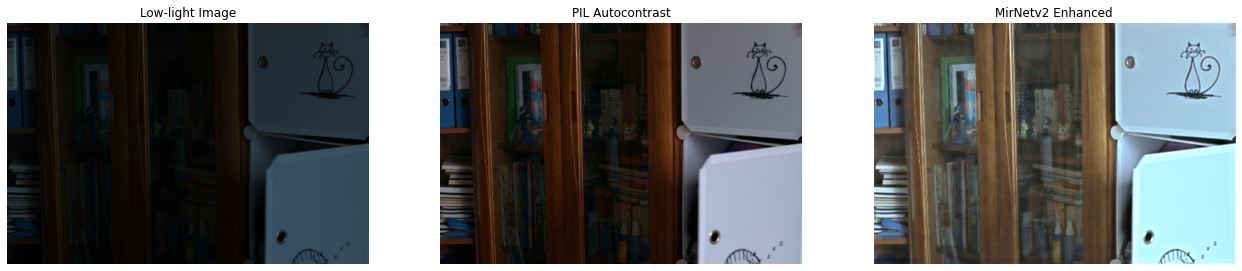

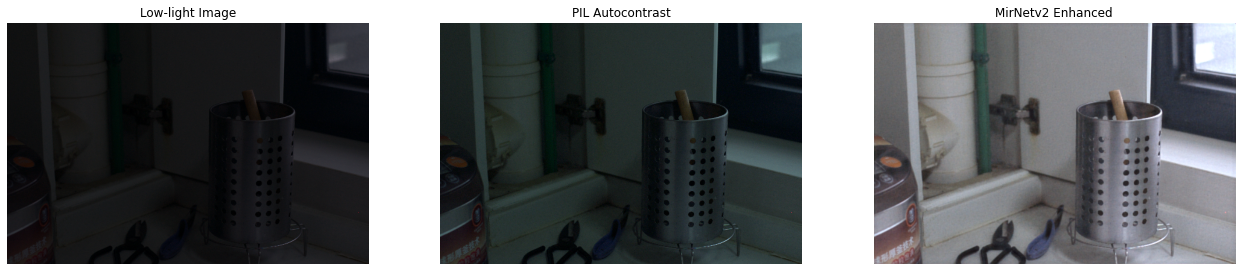

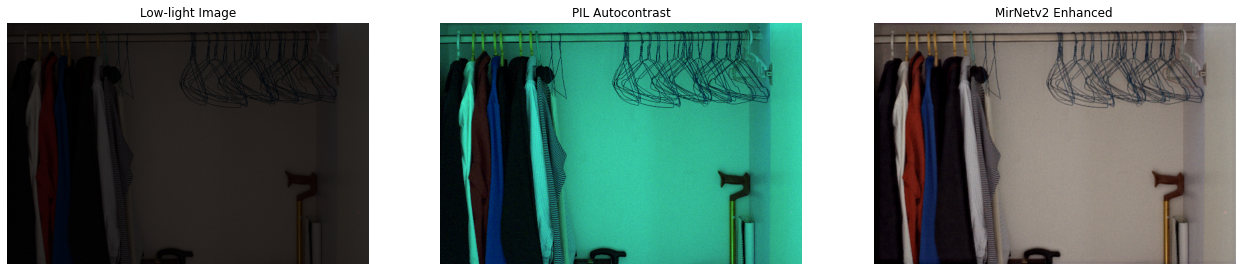

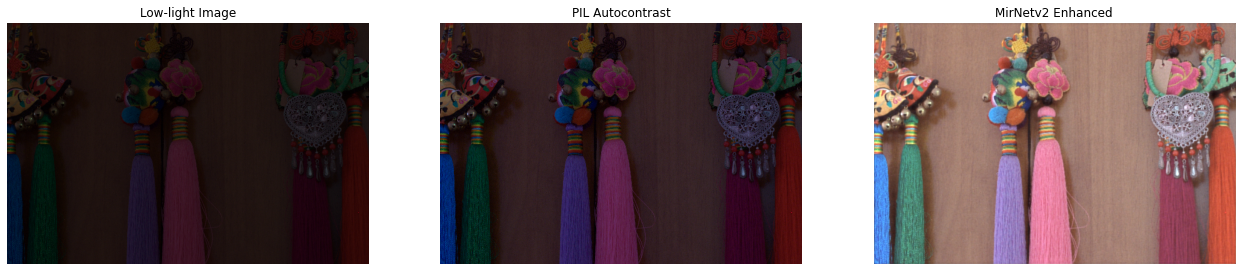

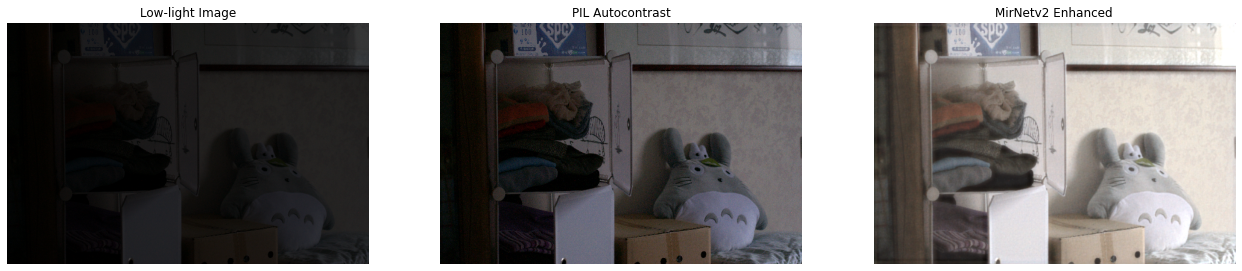

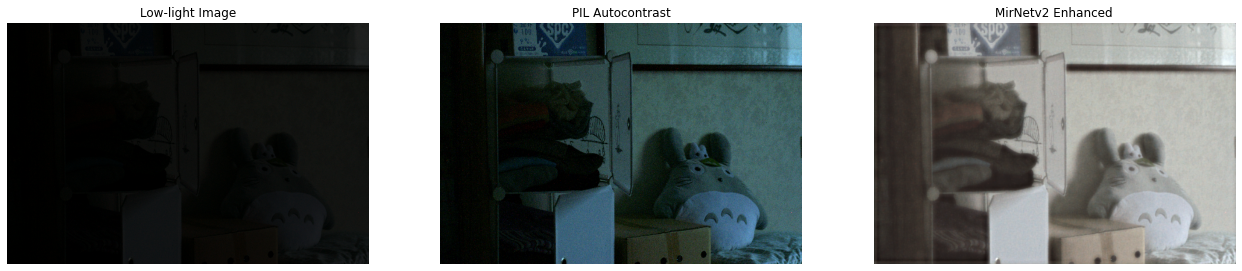

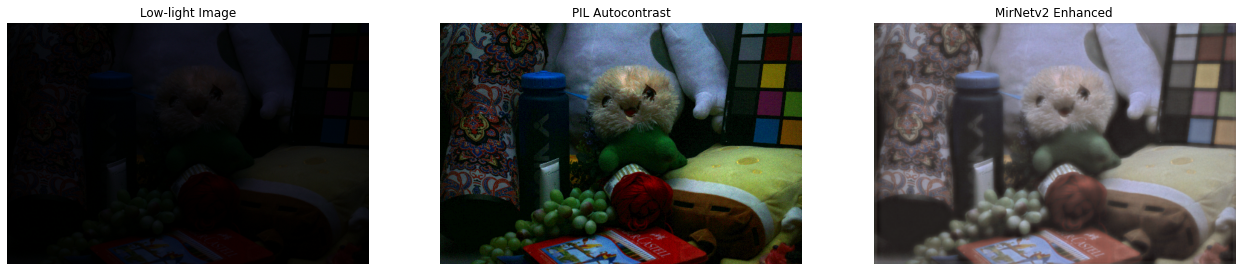

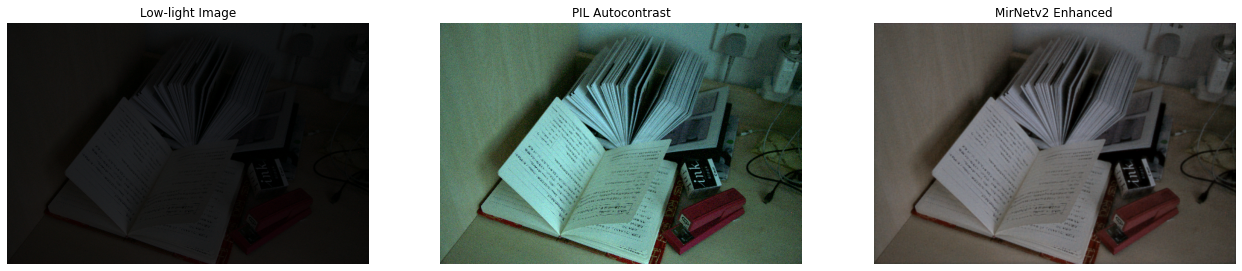

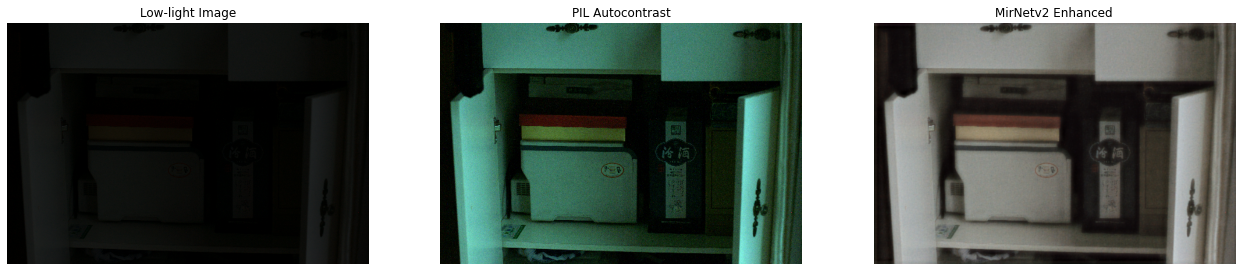

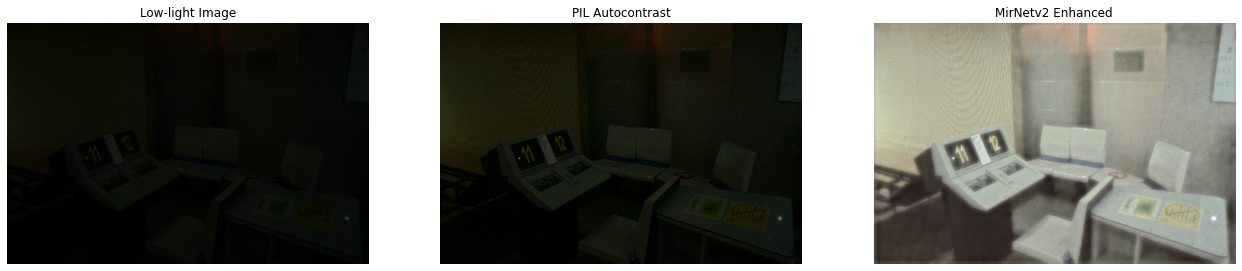

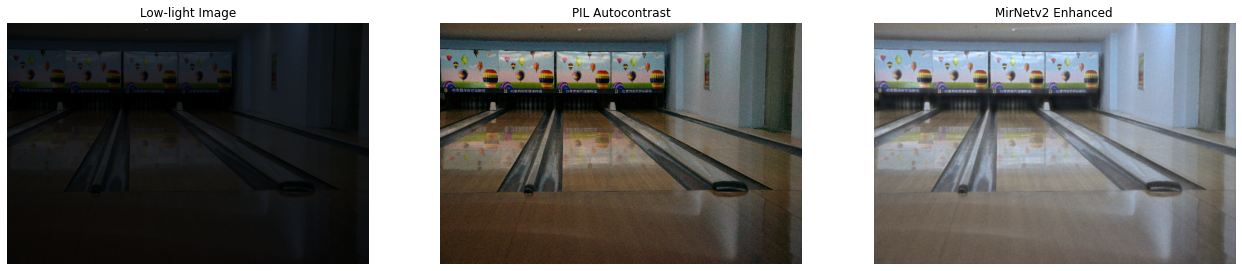

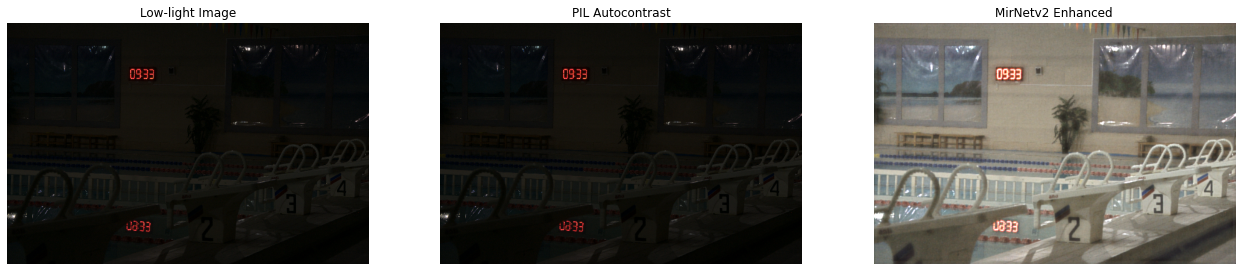

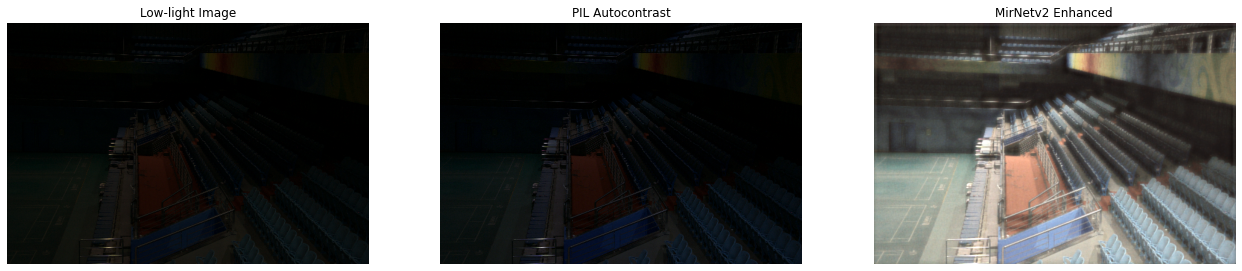

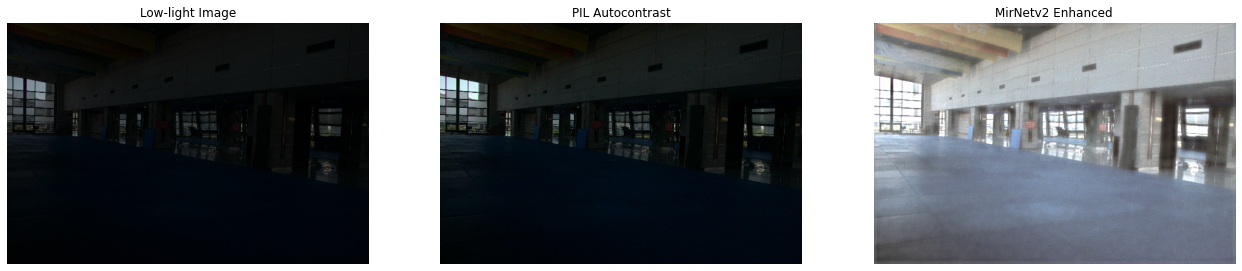

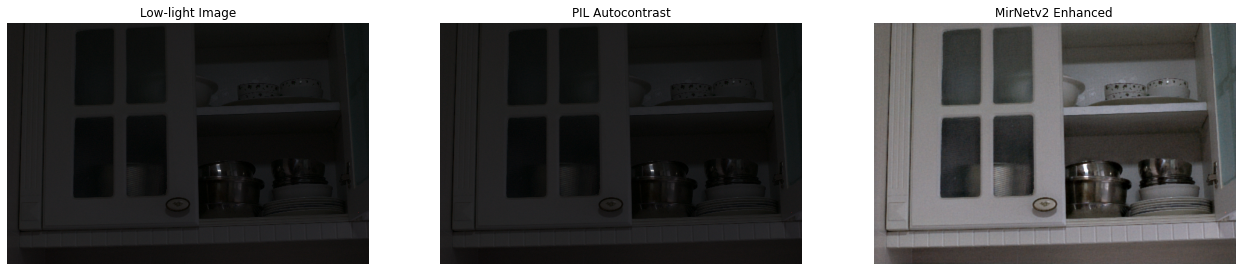

In [ ]:
for low_light_image_file, ground_truth_image_file in zip(TEST_LOW_LIGHT_IMAGES, TEST_GROUND_TRUTH_IMAGES):
    infer_and_visualize(low_light_image_file, ground_truth_image_file, model)

In [ ]:
wandb.finish()